In [1]:
%load_ext autoreload
%autoreload 2

from unsupervised_mt.dataset import Dataset
from unsupervised_mt.train import Trainer 
from unsupervised_mt.models import Embedding, Encoder, DecoderHat, Attention, Discriminator
from unsupervised_mt.batch_loader import BatchLoader
from unsupervised_mt.utils import log_probs2indices, noise

import io
from functools import partial
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
ds = Dataset(corp_paths=('../data/train.lc.norm.tok.en', '../data/train.lc.norm.tok.fr'), 
             emb_paths=('../data/wiki.multi.en.vec', '../data/wiki.multi.fr.vec'), 
             pairs_paths=('../data/train_test_src2tgt.npy', '../data/train_test_tgt2src.npy'), 
             max_length=20, test_size=0.1)

In [3]:
batch_iter = BatchLoader(ds)

In [4]:
hidden_size = 100
num_layers = 3

src_embedding = Embedding(ds.emb_matrix['src']).to(device)
tgt_embedding = Embedding(ds.emb_matrix['tgt']).to(device)

encoder_rnn = nn.GRU(input_size=src_embedding.embedding_dim, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True)
decoder_rnn = nn.GRU(input_size=src_embedding.embedding_dim, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True)
attention = Attention(src_embedding.embedding_dim, hidden_size, max_length=ds.max_length, bidirectional=True)
src_hat = DecoderHat(2*hidden_size, ds.vocabs['src'].size)
tgt_hat = DecoderHat(2*hidden_size, ds.vocabs['tgt'].size)
discriminator = Discriminator(2*hidden_size)

trainer = Trainer(partial(ds.translate_batch_word_by_word, l1='src', l2='tgt'), 
                  partial(ds.translate_batch_word_by_word, l1='tgt', l2='src'), 
                  src_embedding, tgt_embedding, encoder_rnn, decoder_rnn, attention, src_hat, tgt_hat, 
                  discriminator, 
                  ds.get_sos_index('src'), ds.get_sos_index('tgt'), 
                  ds.get_eos_index('src'), ds.get_eos_index('tgt'), 
                  ds.get_pad_index('src'), ds.get_pad_index('tgt'), 
                  device, lr_core=1e-3, lr_disc=1e-3)

In [5]:
trainer.load('../saved_models/final_result1/')

In [ ]:
batch_size = 30
num_steps = 100000

core_losses = []
disc_losses = []
for i in tqdm(range(num_steps)):
    core_loss, disc_loss = trainer.train_step(batch_iter.load_batch(batch_size), weights=(1, 1, 0.3))
    core_losses.append(core_loss)
    disc_losses.append(disc_loss)

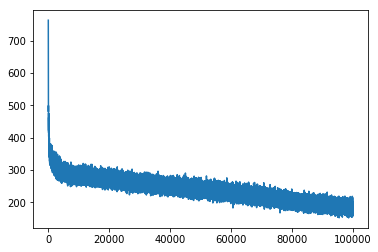

In [6]:
plt.plot(core_losses)

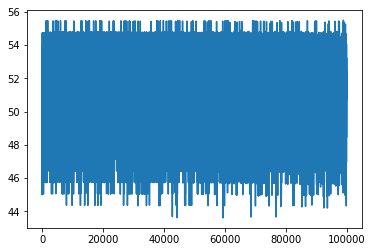

In [48]:
plt.plot(disc_losses)

In [6]:
test_id = np.random.choice(range(len(ds.test)))
batch = batch_iter.load_batch(1, test=True, ids=[test_id])

print(ds.visualize_batch(batch['src'], 'src'))
print(ds.visualize_batch(batch['tgt'], 'tgt'))
print(ds.visualize_batch(trainer.frozen_src2tgt(batch['src']), 'tgt'))
print(ds.visualize_batch(
    log_probs2indices(trainer.src2tgt.evaluate(
        batch['src'].to(device), ds.get_sos_index('tgt'), ds.get_eos_index('tgt'), 20)), 
    'tgt'
))

['a woman and a horse are jumping over a miniature building . <eos>']
['une femme et un cheval sautent par dessus un batiment miniature . <eos>']
['une femme et une cheval sont sautant pendant une miniature immeuble . <eos>']
['une femme et un chien est assis sur un un un un . <eos>']


In [7]:
def clean_batch(batch):
    return [' '.join(filter(lambda w: w != '<eos>' and w != '<pad>', s.split())) for s in batch]

In [8]:
len(ds.test)

2453

In [11]:
with io.open('pred', 'w') as f_pred, io.open('target', 'w') as f_target:
    for idx in range(0, len(ds.test), 50)[:5]:
        source, target = batch_iter.load_batch(0, test=True, ids=range(idx, idx + 50)).values()
        pred = log_probs2indices(trainer.src2tgt.evaluate(
            source.to(device), ds.get_sos_index('tgt'), ds.get_eos_index('tgt')
        ))
        print(*clean_batch(ds.visualize_batch(pred, 'tgt')), sep='\n', file=f_pred)
        print(*clean_batch(ds.visualize_batch(target, 'tgt')), sep='\n', file=f_target)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THC/generic/THCStorage.cu:58

In [12]:
source

tensor([[    4,     4,   117,   594,     5,     4,     4,     4,   109,
             4,     4,     4,   222,    50,     4,     4,     4,   109,
            23,     4,    14,    14,     4,     4,    51,     4,    23,
             4,     4,     4,    14,     4,     4,     4,     4,     4,
             4,     4,     4,    14,     4,    50,    50,   222,   222,
           832,    51,     4,     4,     4],
        [   60,   170,   947,   795,  3454,    11,    11,   131,  1858,
            34,    11,    54,  2049,    60,    11,  2272,    11,    59,
            11,    11,    51,   258,   479,   520,    27,   131,    20,
            34,  1313,    11,    51,    11,  1661,    60,    11,   557,
             5,    11,    11,   557,  1348,   182,    51,   795,  2975,
            54,    27,   526,    19,    11],
        [  166,    25,  2607,  4078,    23,    42,  6081,   415,   168,
             2,    27,    92,  8395,  2029,   366,   233,    27,    27,
            76,    31,    52,  7710,   258,   

In [31]:
! perl ../multi-bleu.perl target < pred

BLEU = 10.58, 44.7/16.5/6.8/2.9 (BP=0.963, ratio=0.964, hyp_len=12621, ref_len=13095)
It is not advisable to publish scores from multi-bleu.perl.  The scores depend on your tokenizer, which is unlikely to be reproducible from your paper or consistent across research groups.  Instead you should detokenize then use mteval-v14.pl, which has a standard tokenization.  Scores from multi-bleu.perl can still be used for internal purposes when you have a consistent tokenizer.
